In [1]:
import os
from utils import utils
import pandas as pd
import torch
from datetime import datetime
from collections import Counter
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np
from transformers.trainer_utils import set_seed
from transformers import RobertaTokenizer
from transformers import AutoConfig, AutoModelWithHeads
from transformers.adapters.composition import Stack
from transformers import TrainingArguments, EvalPrediction, AdapterTrainer


dateTimeObj = datetime.now()

RANDOM_SEED = 42
set_seed(RANDOM_SEED)

os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Data

In [2]:
""" load data """

train_data, val_data, test_data = utils.load_wassa_dataset()

In [3]:
""" get task labels """

prediction_task = 'emotion'

train_labels = list(train_data[prediction_task].values)
val_labels = list(val_data[prediction_task].values)
test_labels = list(test_data[prediction_task].values)

In [4]:
""" count labels and convert labels to ids """

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
id2label = {id:lab for id, lab in enumerate(train_label_counts.keys())}
label2id = {lab:id for id, lab in id2label.items()}


train_labels = [label2id[lab] for lab in train_labels]
val_labels = [label2id[lab] for lab in val_labels]
test_labels = [label2id[lab] for lab in test_labels]

In [5]:
""" save random baseline predictions """

random_preds = utils.random_baseline_predictions(len(val_labels), train_label_counts)
random_pred_counts = Counter(random_preds)

In [6]:
""" make table of label distributions """

train_total = sum(train_label_counts.values())
val_total = sum(val_label_counts.values())
rand_pred_total = sum(random_pred_counts.values())

label_counts = {'label':[], 'train':[], 'dev':[], 'random_preds':[]}

for lab in train_label_counts:
    train_prop = round(train_label_counts[lab] / train_total, 4) * 100
    val_prop = round(val_label_counts[lab] / val_total, 4) * 100
    random_prop = round(random_pred_counts[lab] / rand_pred_total, 4) * 100
    
    label_counts['label'].append(lab)
    label_counts['train'].append(train_prop)
    label_counts['dev'].append(val_prop)
    label_counts['random_preds'].append(random_prop)
    
label_counts = pd.DataFrame(label_counts, columns=label_counts.keys()).sort_values(by=['train'], ascending=False)
label_counts

,label,train,dev,random_preds
0,sadness,34.78,36.30,42.59
3,anger,18.76,28.15,18.52
1,neutral,14.78,9.26,12.59
2,fear,10.43,11.48,5.19
5,surprise,8.82,5.19,7.78
4,disgust,8.01,4.44,7.41
6,joy,4.41,5.19,5.93


In [7]:
""" Prepare dataset for training: feature encodings """

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

train_encodings = tokenizer(list(train_data['essay'].values), truncation=True, padding=True)
val_encodings = tokenizer(list(val_data['essay'].values), truncation=True, padding=True)
test_encodings = tokenizer(list(test_data['essay'].values), truncation=True, padding=True)

In [8]:
""" setup torch dataset """

class EmoDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, id2label):
        self.encodings = encodings
        self.labels = labels
        self.id2label = id2label

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmoDataset(train_encodings, train_labels, id2label)
val_dataset = EmoDataset(val_encodings, val_labels, id2label)
test_dataset = EmoDataset(test_encodings, test_labels, id2label)

# Stacking Emotion Prediction

In [9]:
""" init model """

config = AutoConfig.from_pretrained(
    "roberta-base",
    id2label=id2label,
)
model = AutoModelWithHeads.from_pretrained(
    "roberta-base",
    config=config,
)

/home/nbalguri/.local/lib/python3.9/site-packages/transformers/adapters/models/roberta/adapter_model.py:274: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
/home/nbalguri/.local/lib/python3.9/site-packages/transformers/adapters/models/roberta/adapter_model.py:252: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModelWithHeads: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertF

In [10]:
""" load emotion adapter, using: https://huggingface.co/AdapterHub/roberta-base-pf-emotion """

emotion_adapter = model.load_adapter('AdapterHub/roberta-base-pf-emotion', source="hf")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
""" add adapter for emotion prediction task """

adapter_name = "EMO_emotion_stack"

model.add_adapter(adapter_name)
model.add_classification_head(adapter_name, num_labels=len(id2label))

In [12]:
""" activate adapter stack """

model.active_adapters = Stack(emotion_adapter, adapter_name)

In [13]:
""" activate adapter for training """

model.train_adapter([adapter_name])

In [14]:
""" training arguments """

approach = 'emotion-stack'
training_output_dir = f"./training_output/{approach}/{prediction_task}_{dateTimeObj.hour}{dateTimeObj.minute}-{dateTimeObj.day}-{dateTimeObj.month}"
num_train_epochs=20
per_device_train_batch_size=32
per_device_eval_batch_size=32
metric_for_best_model='eval_f1_macro'
warmup_steps=1000
weight_decay=0.1
learning_rate=1e-04


training_args = TrainingArguments(
    seed=RANDOM_SEED,
    output_dir=training_output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    learning_rate=learning_rate,
     warmup_steps=warmup_steps,
     weight_decay=weight_decay,
    logging_dir='./logs',
    logging_steps=50,
    eval_steps=50,
    save_steps=50, # NOTE: saving every 50 steps uses about 527M space
    evaluation_strategy='steps',
    disable_tqdm=False,
    overwrite_output_dir=True,
    remove_unused_columns=False,
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
""" setup trainer """

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1) 
    metrics = {"accuracy": (preds == p.label_ids).mean()}
    
    for avg in ['weighted', "macro", "micro"]:
        metrics[f"f1_{avg}"] = f1_score(p.label_ids, preds, average=avg)
        
    for id, lab in id2label.items():
        metrics[f"f1_{id2label[id]}"] = f1_score(p.label_ids, preds, average='micro', labels=[id])
        
    return metrics


trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [16]:
""" train """

trainer.train()

/home/nbalguri/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1860
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1180
  Number of trainable parameters = 2085709


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,F1 Micro,F1 Sadness,F1 Neutral,F1 Fear,F1 Anger,F1 Disgust,F1 Surprise,F1 Joy
50,2.006400,2.034414,0.059259,0.018394,0.034643,0.059259,0.000000,0.142857,0.000000,0.000000,0.000000,0.099644,0.000000
100,1.962400,1.957761,0.362963,0.193317,0.076087,0.362963,0.532609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
150,1.887200,1.851429,0.362963,0.193317,0.076087,0.362963,0.532609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200,1.824000,1.739692,0.362963,0.193317,0.076087,0.362963,0.532609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
250,1.755100,1.674301,0.362963,0.193317,0.076087,0.362963,0.532609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
300,1.748400,1.646041,0.362963,0.193317,0.076087,0.362963,0.532609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
350,1.660600,1.469458,0.414815,0.297448,0.147510,0.414815,0.563050,0.206897,0.000000,0.262626,0.000000,0.000000,0.000000
400,1.433800,1.181229,0.603704,0.548975,0.369009,0.603704,0.737778,0.333333,0.390244,0.641711,0.000000,0.480000,0.000000
450,1.257600,1.024680,0.640741,0.603335,0.430300,0.640741,0.744186,0.478261,0.600000,0.689655,0.000000,0.500000,0.000000
500,1.113600,0.968561,0.662963,0.646647,0.514244,0.662963,0.772277,0.518519,0.642857,0.699387,0.333333,0.500000,0.133333


***** Running Evaluation *****
  Num examples = 270
  Batch size = 32
Saving model checkpoint to ./training_output/emotion-stack/emotion_1817-7-4/checkpoint-50
Configuration saved in ./training_output/emotion-stack/emotion_1817-7-4/checkpoint-50/emotion/adapter_config.json
Module weights saved in ./training_output/emotion-stack/emotion_1817-7-4/checkpoint-50/emotion/pytorch_adapter.bin
Configuration saved in ./training_output/emotion-stack/emotion_1817-7-4/checkpoint-50/emotion/head_config.json
Module weights saved in ./training_output/emotion-stack/emotion_1817-7-4/checkpoint-50/emotion/pytorch_model_head.bin
Configuration saved in ./training_output/emotion-stack/emotion_1817-7-4/checkpoint-50/EMO_emotion_stack/adapter_config.json
Module weights saved in ./training_output/emotion-stack/emotion_1817-7-4/checkpoint-50/EMO_emotion_stack/pytorch_adapter.bin
Configuration saved in ./training_output/emotion-stack/emotion_1817-7-4/checkpoint-50/EMO_emotion_stack/head_config.json
Module weigh

TrainOutput(global_step=1180, training_loss=1.169405581587452, metrics={'train_runtime': 18321.3858, 'train_samples_per_second': 2.03, 'train_steps_per_second': 0.064, 'total_flos': 4371713319448800.0, 'train_loss': 1.169405581587452, 'epoch': 20.0})

# Evaluate

In [17]:
""" output eval metrics from best model """

#trainer.model.cuda()
eval_output = trainer.evaluate()
eval_result = eval_output[metric_for_best_model]

pd.DataFrame({'metric':list(eval_output.keys()), 'value': list(eval_output.values())}, columns=['metric', 'value'])

***** Running Evaluation *****
  Num examples = 270
  Batch size = 32


,metric,value
0,eval_loss,0.888062
1,eval_accuracy,0.685185
2,eval_f1_weighted,0.687807
3,eval_f1_macro,0.616604
4,eval_f1_micro,0.685185
5,eval_f1_sadness,0.778947
6,eval_f1_neutral,0.524590
7,eval_f1_fear,0.721311
8,eval_f1_anger,0.687898
9,eval_f1_disgust,0.416667


***** Running Prediction *****
  Num examples = 270
  Batch size = 32


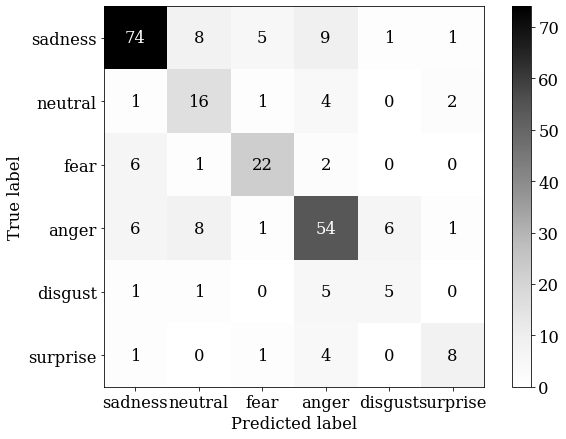

In [18]:
""" plot confusion matrix of dev set preditions """

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size': 16.4,
    'figure.figsize': [10,7]
})
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

p = trainer.predict(val_dataset)
preds = np.argmax(p.predictions, axis=1)

cm = confusion_matrix(p.label_ids, preds, labels=[0,1,2,3,4,5])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[id2label[i] for i in range(6)])

disp.plot(cmap='Greys')
plt.show()

In [19]:
""" output label distribution """

pred_counts = Counter(preds)
pred_total = sum(pred_counts.values())

l = []
for lab in label_counts.label:
    lab = label2id[lab]
    if lab in pred_counts:
        prop = round(pred_counts[lab] / pred_total, 4) * 100
    else:
        prop = 0.0
    l.append(prop)

label_counts['model_preds_eval'] = l
label_counts

,label,train,dev,random_preds,model_preds_eval
0,sadness,34.78,36.30,42.59,34.07
3,anger,18.76,28.15,18.52,30.00
1,neutral,14.78,9.26,12.59,13.33
2,fear,10.43,11.48,5.19,11.11
5,surprise,8.82,5.19,7.78,4.44
4,disgust,8.01,4.44,7.41,4.44
6,joy,4.41,5.19,5.93,2.59


# Test predictions

In [20]:
""" make predictions on test dataset """

p = trainer.predict(test_dataset)
preds = np.argmax(p.predictions, axis=1)
preds = [id2label[p] for p in preds]


***** Running Prediction *****
  Num examples = 525
  Batch size = 32


In [21]:
""" output label distribution """

pred_counts = Counter(preds)
pred_total = sum(pred_counts.values())

l = []
for lab in label_counts.label:
    if lab in pred_counts:
        prop = round(pred_counts[lab] / pred_total, 4) * 100
    else:
        prop = 0.0
    l.append(prop)

label_counts['model_preds_test'] = l
label_counts

,label,train,dev,random_preds,model_preds_eval,model_preds_test
0,sadness,34.78,36.30,42.59,34.07,32.57
3,anger,18.76,28.15,18.52,30.00,26.86
1,neutral,14.78,9.26,12.59,13.33,14.10
2,fear,10.43,11.48,5.19,11.11,10.48
5,surprise,8.82,5.19,7.78,4.44,6.67
4,disgust,8.01,4.44,7.41,4.44,6.10
6,joy,4.41,5.19,5.93,2.59,3.24


In [22]:
""" save predictions """

pred_file = f"{approach}-{metric_for_best_model}-{round(eval_result * 100, 4)}_{dateTimeObj.hour}{dateTimeObj.minute}-{dateTimeObj.day}-{dateTimeObj.month}.tsv"
pred_path = f'./predictions/{prediction_task}/{pred_file}'
os.makedirs(f'./predictions/{prediction_task}/', exist_ok=True)
pd.Series(preds).to_csv(pred_path, sep='\t', header=False, index=False)
print("saved predictions to",pred_path)

saved predictions to ./predictions/emotion/emotion-stack-eval_f1_macro-61.6604_1817-7-4.tsv


# Save the adapter

In [ ]:
# trainer.model.save_adapter(f"./trained_adapters/EMO_emotion_stack", "EMO_emotion_stack")